---- Explanation about the structure of the code ----

- On Section 1 and 2 we have created the functions for clean and preprocess and both of them are applied at the end of section 2
- On Section 3 we have created the function for applying different vectorizers
- On Section 4 we have created the functions for applying the the ML models with the different vectorizers
- On Section 5. Results, we simply call all the above functions for getting the results on the same place and make it easier for comparisons

## <font color='red'> Required Packages

In [ ]:
!pip install --force-reinstall --no-cache-dir scipy==1.11.4


In [ ]:
!pip uninstall -y numpy gensim
!pip install numpy==1.26.4 gensim==4.3.2 --no-cache-dir

In [ ]:
!pip3 install wordcloud
!pip3 install nltk
!pip3 install numpy
!pip3 install pandas
!pip3 install gensim

In [ ]:
# For Bert
!pip install transformers
!pip3 install scikit-learn seaborn torch torchvision torchaudio

In [ ]:
import os
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re
import string
import warnings
import math

# Preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

# Vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk import ngrams

# Models & Evaluation
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, auc
#import torch
import transformers as ppb
#import w2v
import gensim
from gensim.models import Word2Vec

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

In [4]:
warnings.filterwarnings(action='ignore')

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.6.0+cu124
True


## <font color='red'> 1. Load Data

In [ ]:
#computer_path = os.getcwd()
#df = pd.read_csv(f"{computer_path}/Sentiment Analysis for Mental Health.csv")
#df

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
csv_path = '/content/Sentiment Analysis for Mental Health.csv'
df = pd.read_csv(csv_path)
df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


#### Let's start performing some EDA to take a quick view and understand our data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
df.shape

(53043, 3)

In [8]:
# Drop unecessary column "Unnamed: 0"
df = df.drop(columns=["Unnamed: 0"], axis=1)
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


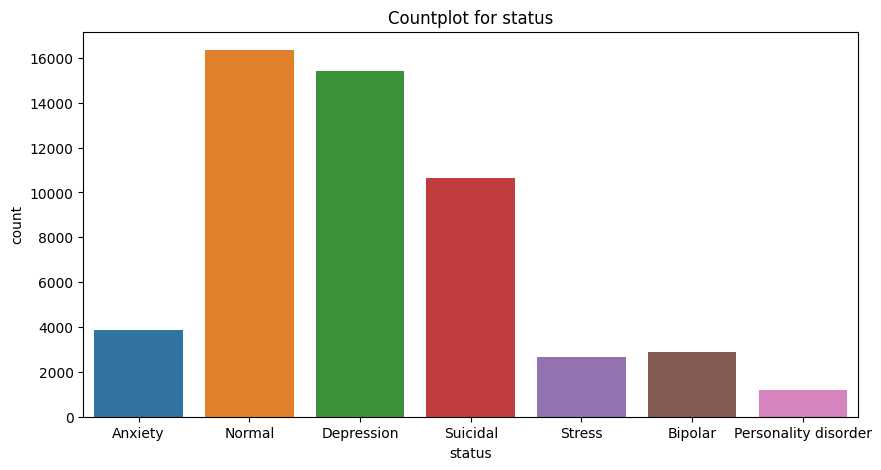

In [ ]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x='status', hue='status')
plt.title('Countplot for status')

print(df['status'].value_counts(ascending=False))

Text(0.5, 1.0, 'Histogram for status')

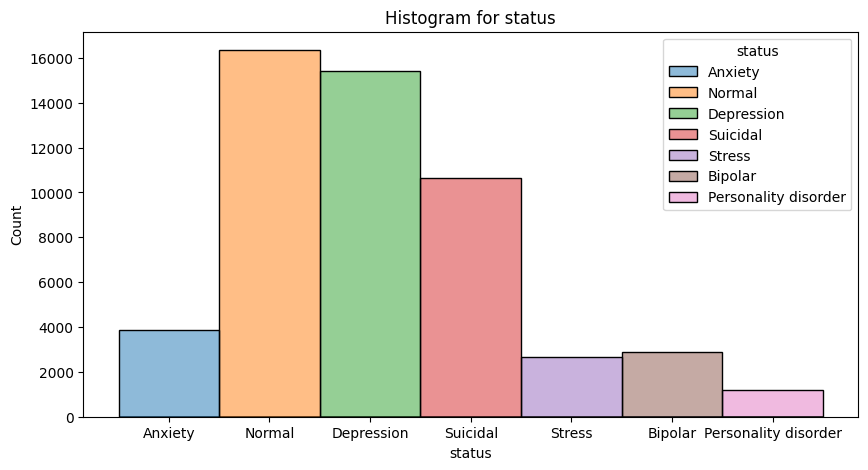

In [ ]:
plt.figure(figsize=[10,5])
sns.histplot(data=df, x='status', hue='status')
plt.title('Histogram for status')

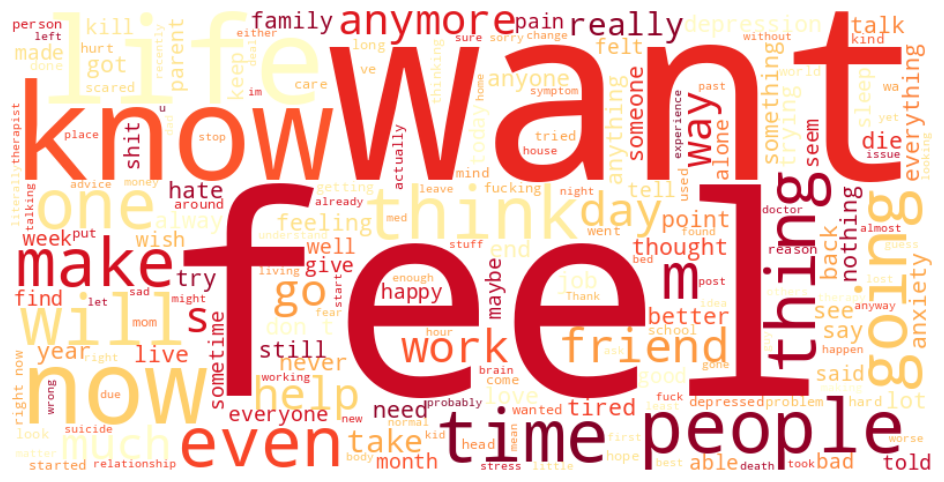

In [ ]:
all_text = ' '.join(df['statement'].astype(str))
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='YlOrRd').generate(all_text)

# Plota
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

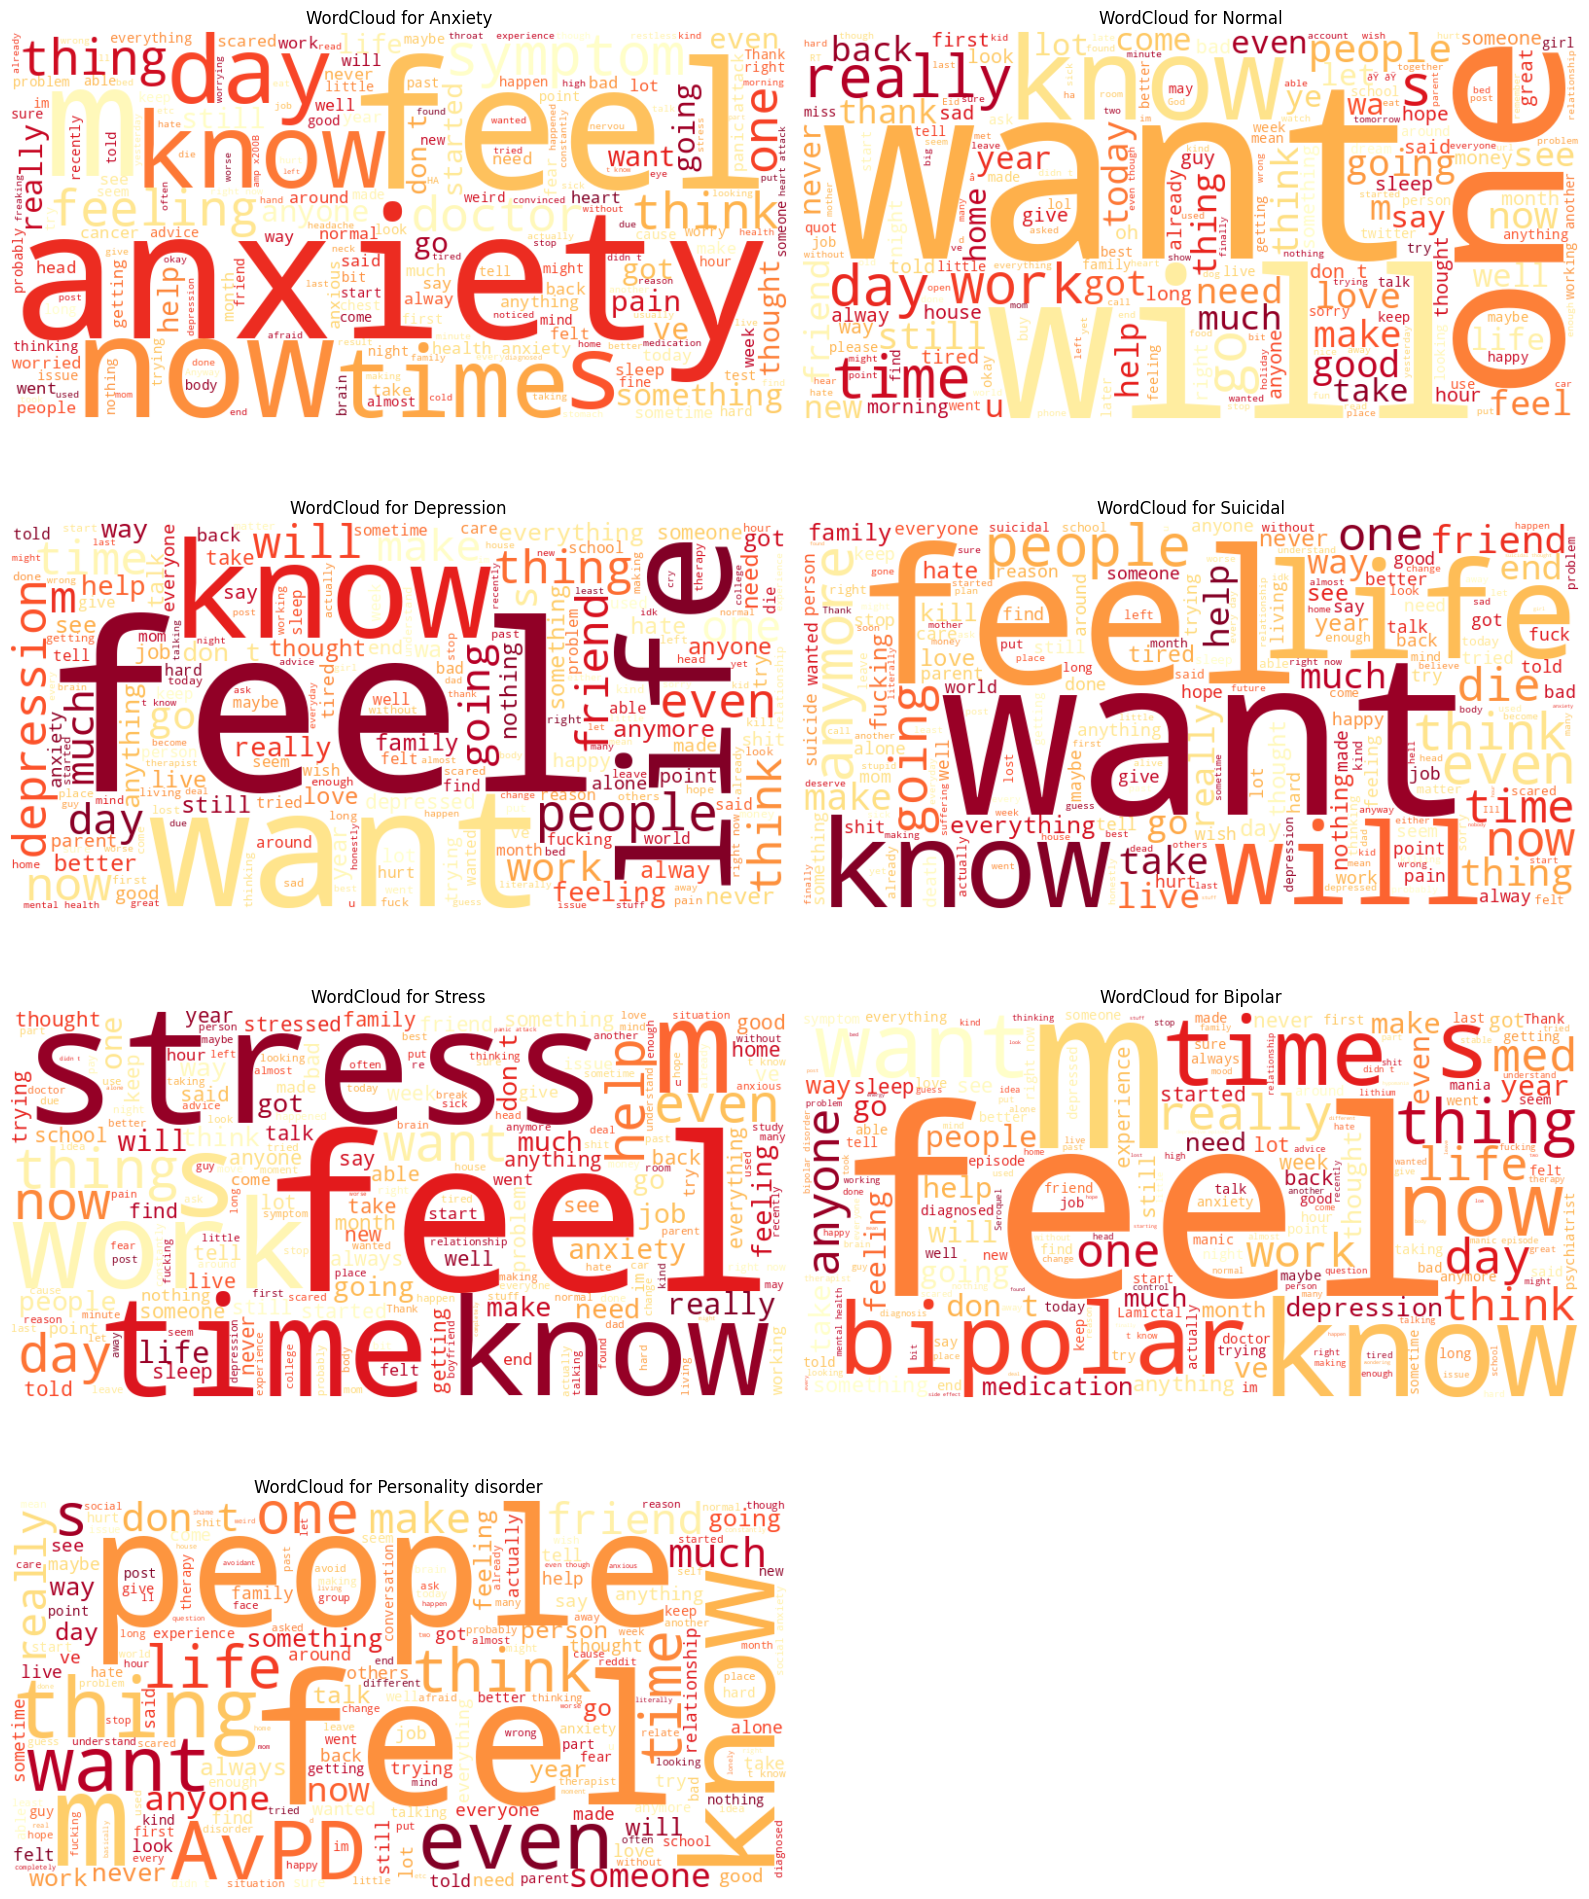

In [ ]:
# Now we will display the most common words for each mental disorder
categories = df['status'].unique()

# Setup plot grid size
num_cats = len(categories)
cols = 2
rows = (num_cats + 1) // cols

plt.figure(figsize=(cols * 8, rows * 5))

for i, cat in enumerate(categories, 1):
    # Join all text from 'statement' where 'status' == cat
    text = ' '.join(df.loc[df['status'] == cat, 'statement'].dropna().astype(str))

    wc = WordCloud(width=800, height=400,
                   background_color='white',
                   colormap='YlOrRd').generate(text)

    plt.subplot(rows, cols, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {cat}')

plt.tight_layout()
plt.show()


#### Cleaning

In [9]:
print((df.isnull().sum()/len(df)) * 100)

statement    0.682465
status       0.000000
dtype: float64


In [10]:
# Since missing values are equal to 0.68% < 5% we can just drop them
df = df.dropna()
df.isnull().sum()

,0
statement,0
status,0


In [11]:
# Since status is a label, everything is duplicated, so we care only about the statement column
df['statement'].duplicated().sum()

np.int64(1608)

In [12]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [13]:
df.describe()

,statement,status
count,51093,51093
unique,51073,7
top,#NAME?,Normal
freq,4,16040


In [14]:
df['statement'].head()

,statement
0,oh my gosh
1,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ..."
3,I've shifted my focus to something else but I'...
4,"I'm restless and restless, it's been a month n..."


In [15]:
# Train-test split early on

X = df['statement']
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)  # shuffle=True, so the algorithm does not remember patterns

In [16]:
print("X Train", X_train.shape)
print("X Test", X_test.shape)
print("y Train", y_train.shape)
print("y Test", y_test.shape)

X Train (40874,)
X Test (10219,)
y Train (40874,)
y Test (10219,)


In [17]:
# After shuffling, take a quick glance on statement's text
for i, text in enumerate(X_train[:30]):
    print("Statement:", text)
    print("-"*130)

Statement: i went to macy's and picked it out.
----------------------------------------------------------------------------------------------------------------------------------
Statement: AAAAH SARAH #SPACEMUNDINHO
----------------------------------------------------------------------------------------------------------------------------------
Statement: So I just overdosed on a shit ton of prescription meds, I also had some aleve, Tylenol, Advil, and some alcohol. I also ate a crap ton of vitamin gummies with iron in them, so that will help. Ill just sit here and wait it out for a bit, seeya Its begun
----------------------------------------------------------------------------------------------------------------------------------
Statement: is reading through some interesting articles on our own Extranet, surprisingly good stuff
----------------------------------------------------------------------------------------------------------------------------------
Statement: kids are crying

After inspection, we have many things we want to exclude like: "---   **tl;dr**:", emojies and more

In [18]:
def clean(text):
    # Filling up the missing values with space ''
    if not isinstance(text, str):
        return ''

    # --- Remove characters we don't need ---
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)

    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)

    # Remove punctuation and other special characters
    text = re.sub(r'[_\W]+', ' ', text)

    # Lowercase
    text = text.lower()

    return text.strip()

## <font color='red'> 2. Pre-Process

- Tokenize
- Stopwords removal
- Stemming/Lemmatization
- ngrams

In [19]:
lemma = WordNetLemmatizer()

In [20]:
def preprocess(text):
    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    # We use lemma over stem because we need more accurate words despite the fact that it requires more time and computational sources
    new_tokens = []
    for word in tokens:
        if word not in stopwords.words("english"):
            lemma_tokens = lemma.lemmatize(word)
            new_tokens.append(lemma_tokens)

    return new_tokens

In [21]:
# Train data
X_train_cleaned = X_train.apply(clean)
X_train_preprocessed = X_train_cleaned.apply(preprocess)

# Join them back to create strings
# An appropriate technique for the vectorizers
X_train_joined = X_train_preprocessed.apply(lambda tokens: ' '.join(tokens))

# Test data
X_test_cleaned = X_test.apply(clean)
X_test_preprocessed = X_test_cleaned.apply(preprocess)

# Same for the test set
X_test_joined = X_test_preprocessed.apply(lambda tokens: ' '.join(tokens))

In [22]:
X_train_joined.shape

(40874,)

In [23]:
X_train_joined[:10]

,statement
30457,went macy picked
1745,aaaah sarah spacemundinho
24131,overdosed shit ton prescription med also aleve...
36606,reading interesting article extranet surprisin...
32950,kid cry climbing
11683,hi name kenzie 14 year old live france last ye...
24251,life kid good strange parent together convince...
4912,awwwwwwwwwwww people funny
33978,fear brain aneurysm hi everything started apri...
31395,yes dad


## <font color='red'> 3. Text Embeddings

In [24]:
# Function of inserting the vectorizer and implement the fit and transform
def apply_vectorizer(vectorizer, X_train, X_test):
    X_train_vec = vectorizer.fit_transform(X_train)  # Fit and transform the training data
    X_test_vec = vectorizer.transform(X_test)  # Apply only transform for avoiding test set to learn patterns

    print(f"{vectorizer} Feature Sample:")
    print(X_train_vec.shape)
    print("-" * 50)
    print(X_train_vec[:10])

    return X_train_vec, X_test_vec, vectorizer

#### <font color='red'> 3.1 Simple BoW


In [ ]:
count = CountVectorizer()

X_train_count, X_test_count, count = apply_vectorizer(count, X_train_joined, X_test_joined)

#### <font color='red'> 3.2 TF-IDF

In [ ]:
tfidf = TfidfVectorizer()

X_train_tfidf, X_test_tfidf, tfidf = apply_vectorizer(tfidf, X_train_joined, X_test_joined)

#### <font color='red'> 3.2 Trigrams

In [ ]:
count_ngrams = CountVectorizer(ngram_range=(1,3))

X_train_count_ngrams, X_test_count_ngrams, count_ngrams = apply_vectorizer(count_ngrams, X_train_joined, X_test_joined)

CountVectorizer(ngram_range=(1, 3)) Feature Sample:
(40874, 2726064)
--------------------------------------------------
  (0, 2616279)	1
  (0, 1463511)	1
  (0, 1796869)	1
  (0, 2618436)	1
  (0, 1463512)	1
  (0, 2618437)	1
  (1, 29678)	1
  (1, 2013478)	1
  (1, 2184194)	1
  (1, 29681)	1
  (1, 2013479)	1
  (1, 29682)	1
  (2, 1722607)	1
  (2, 2087450)	1
  (2, 2442045)	2
  (2, 1842454)	1
  (2, 1513435)	1
  (2, 98677)	2
  (2, 82650)	1
  (2, 2495154)	1
  (2, 64857)	1
  (2, 81357)	1
  (2, 196475)	1
  (2, 486938)	1
  (2, 2545086)	1
  :	:
  (8, 2029655)	1
  (8, 2382771)	1
  (8, 2285642)	1
  (8, 120955)	1
  (8, 965921)	1
  (8, 1307174)	1
  (8, 1002856)	1
  (8, 2000755)	1
  (8, 2347969)	1
  (8, 754668)	1
  (8, 984189)	1
  (8, 613615)	1
  (8, 296373)	1
  (8, 1844352)	1
  (8, 1128008)	1
  (8, 2338337)	1
  (8, 113276)	1
  (8, 2373067)	1
  (8, 1126362)	1
  (8, 296391)	1
  (8, 1844473)	1
  (8, 1563235)	1
  (9, 508915)	1
  (9, 2715120)	1
  (9, 2715320)	1


#### <font color='red'> 3.4 Word2Vec embedding

In [ ]:
import gensim
from gensim.models import Word2Vec

In [ ]:
# Creating a function for Max pooling for Word2Vec
def max_feature_vector(words, model, num_features=300):
    feature_vec = np.zeros((num_features,), dtype='float32')
    for word in words:
        if word in model:
            feature_vec = np.maximum(feature_vec, model[word])
    return feature_vec

all_sentences = list(X_train_preprocessed) + list(X_test_preprocessed)

w2v_model = Word2Vec(
    sentences=all_sentences,
    vector_size=300,
    window=5,
    min_count=2,
    workers=4,
    sg=1
)

trained_wv = w2v_model.wv


In [ ]:
# Convert to vectors
X_train_w2v = np.array([max_feature_vector(doc, trained_wv, 300) for doc in X_train_preprocessed])
X_test_w2v = np.array([max_feature_vector(doc, trained_wv, 300) for doc in X_test_preprocessed])

In [ ]:
# Logistic Regression Setup
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    solver='saga',
    penalty='l2',
    C=0.5,
    random_state=42
)

#### <font color='red'> 3.5 BERT Embedding

In [25]:
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader


In [26]:
#Load model and tokenizer

def load_model(model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    return tokenizer, model

In [27]:
# Tokenization
def tokenize_texts(tokenizer, texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )



In [28]:
# Dataset wrapper
class EncodedDataset(Dataset):
    def __init__(self, encodings):
        self.input_ids      = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            'input_ids':      self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }

In [29]:
#DataLoader creation
def create_dataloader(encodings, batch_size, shuffle=False):
    dataset = EncodedDataset(encodings)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [30]:
# Embedding extraction
def extract_embeddings(model, dataloader, device):
    model.to(device)
    all_embs = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled = outputs.pooler_output.cpu().numpy()
            all_embs.append(pooled)

            torch.cuda.empty_cache()

    return np.vstack(all_embs)


In [39]:
# Pipeline execution
def run_pipeline(X_train_joined, X_test_joined, batch_size=16):
    tokenizer, model = load_model()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_enc = tokenize_texts(tokenizer, X_train_joined)
    test_enc  = tokenize_texts(tokenizer, X_test_joined)

    train_loader = create_dataloader(train_enc, batch_size)
    test_loader  = create_dataloader(test_enc, batch_size)

    X_train_bert = extract_embeddings(model, train_loader, device)
    X_test_bert  = extract_embeddings(model, test_loader, device)

    return X_train_bert, X_test_bert, train_enc, test_enc


## <font color='red'> 4. ML models

- Naïve Bayes
- Logistic Regression
- Random Forest

In [ ]:
# Confusion Matrix Visualization
class_names = ['Anxiety', 'Bipolar', 'Depression', 'Normal',
               'Personality disorder', 'Stress', 'Suicidal']

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Model training, evaluation, and visualization function
def models_and_evaluation(X_train_vec, X_test_vec, y_train, y_test, cv_folds=5):
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier()
    }


    for name, model in models.items():

        # Stratified k-fold Cross Validation
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_vec, y_train, cv=skf, scoring='accuracy')
        print(f"Cross-Validation Accuracy (mean over {cv_folds} folds): {cv_scores.mean():.4f}")
        print(f"Individual Fold Accuracies: {cv_scores}")

        model.fit(X_train_vec, y_train)
        y_train_pred = model.predict(X_train_vec)
        y_test_pred = model.predict(X_test_vec)

        cm_test = confusion_matrix(y_test, y_test_pred)
        plot_confusion_matrix(cm_test, f'{name} - Confusion Matrix (Test Data)')

        cm_train = confusion_matrix(y_train, y_train_pred)
        plot_confusion_matrix(cm_train, f'{name} - Confusion Matrix (Train Data)')

        # Scores and Reports
        print("\t \t ---- Model Performance on Test data ----")
        print(classification_report(y_test, y_test_pred))

        print("\t \t ---- Model Performance on Training data ----")
        print(classification_report(y_train, y_train_pred))

        print("=" * 141)

----------------------

> ### <font color='blue'> <I> Next Sections' structure
>
>Now the way we will approach to compare the results
>
>- Section 4: Comparison of ML techniques with different vectorization techniques - We keep the best performed
> - Section 5: Comparison of NN with BERT & Word2vec - We keep the best performed
> - Section 6: LLM
> - Section 7: Final Evaluation - Comparison between the best performed on Sections 4, 5, 6

----------------------

## <font color='red'> 4. Results & Comparison of traditional ML techniques

> - Confusion Matrix for all three models with each different vectorization technique both on Test and Train data -> Heatmap graph
> - precision - recall - f1-score - accuracy

> #### <font color='red'> 4.1 Naive Bayes - Logistic Regression - Random Forest with CountVectorizer

!!!!! Naive Bayes - Logistic Regression - Random Forest with CountVectorizer !!!!!
Cross-Validation Accuracy (mean over 5 folds): 0.6324
Individual Fold Accuracies: [0.63180428 0.62960245 0.62788991 0.64036697 0.63212625]


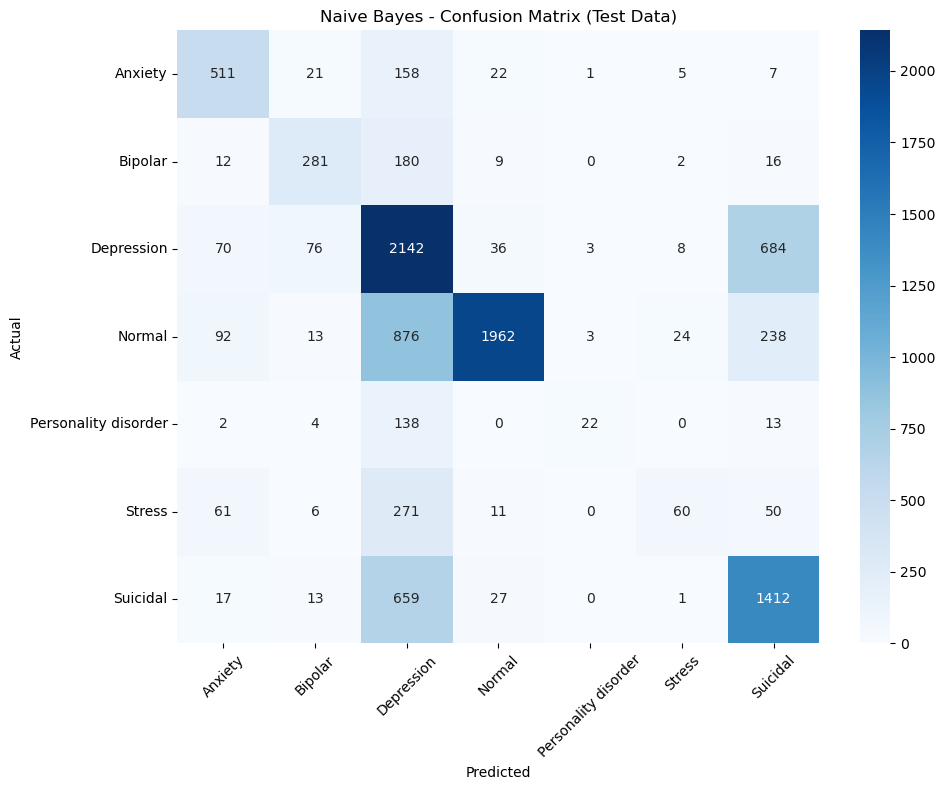

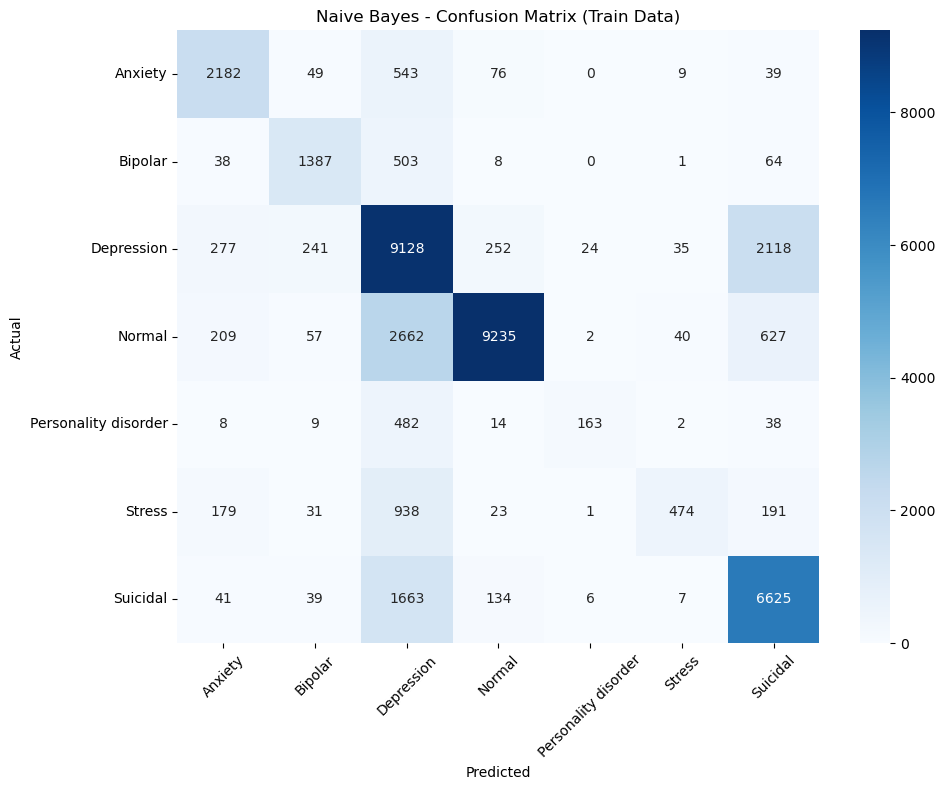

	 	 ---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.67      0.70      0.69       725
             Bipolar       0.68      0.56      0.61       500
          Depression       0.48      0.71      0.58      3019
              Normal       0.95      0.61      0.74      3208
Personality disorder       0.76      0.12      0.21       179
              Stress       0.60      0.13      0.21       459
            Suicidal       0.58      0.66      0.62      2129

            accuracy                           0.63     10219
           macro avg       0.67      0.50      0.52     10219
        weighted avg       0.68      0.63      0.62     10219

	 	 ---- Model Performance on Training data ----
                      precision    recall  f1-score   support

             Anxiety       0.74      0.75      0.75      2898
             Bipolar       0.77      0.69      0.73      2001
          Depression       0.57   

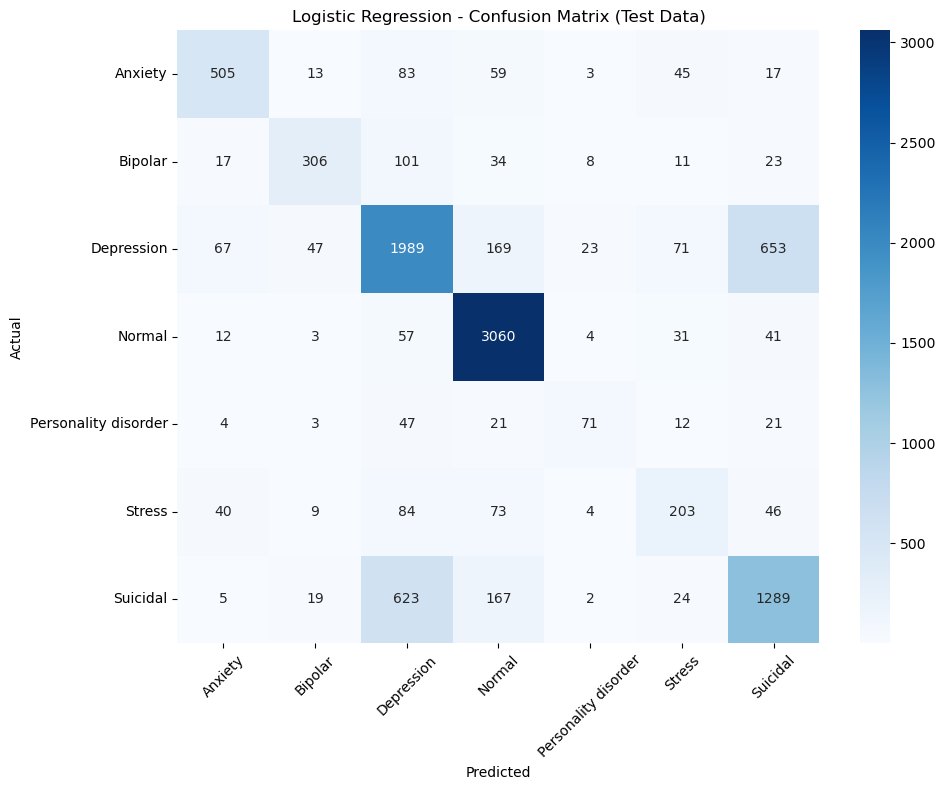

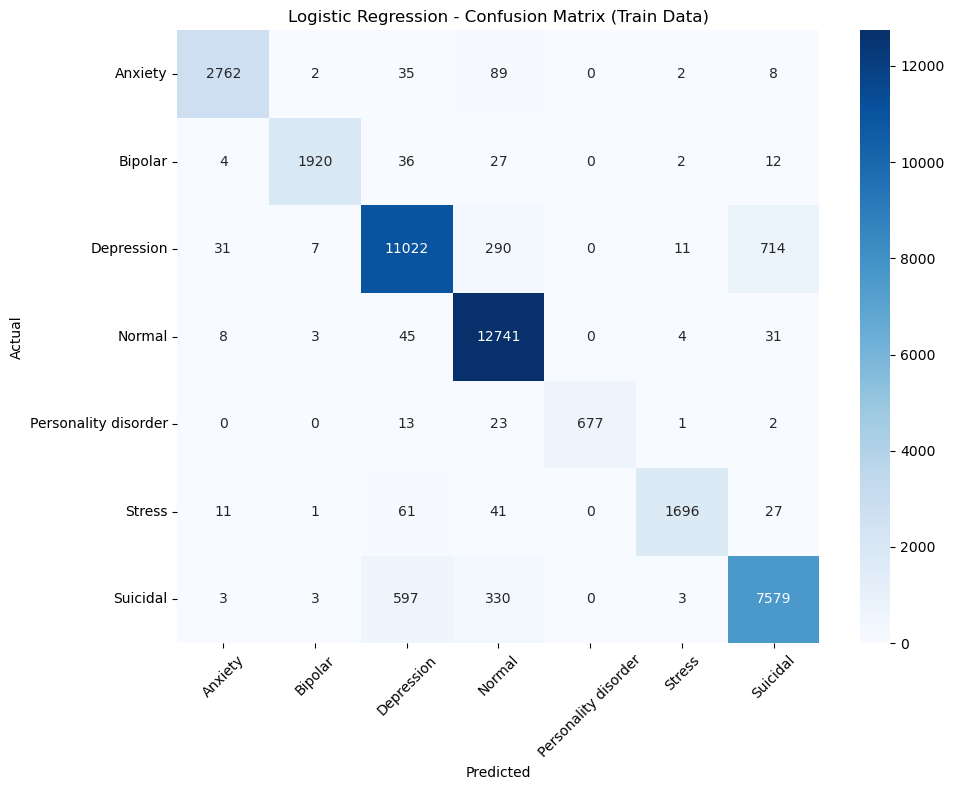

	 	 ---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.78      0.70      0.73       725
             Bipolar       0.77      0.61      0.68       500
          Depression       0.67      0.66      0.66      3019
              Normal       0.85      0.95      0.90      3208
Personality disorder       0.62      0.40      0.48       179
              Stress       0.51      0.44      0.47       459
            Suicidal       0.62      0.61      0.61      2129

            accuracy                           0.73     10219
           macro avg       0.69      0.62      0.65     10219
        weighted avg       0.72      0.73      0.72     10219

	 	 ---- Model Performance on Training data ----
                      precision    recall  f1-score   support

             Anxiety       0.98      0.95      0.97      2898
             Bipolar       0.99      0.96      0.98      2001
          Depression       0.93   

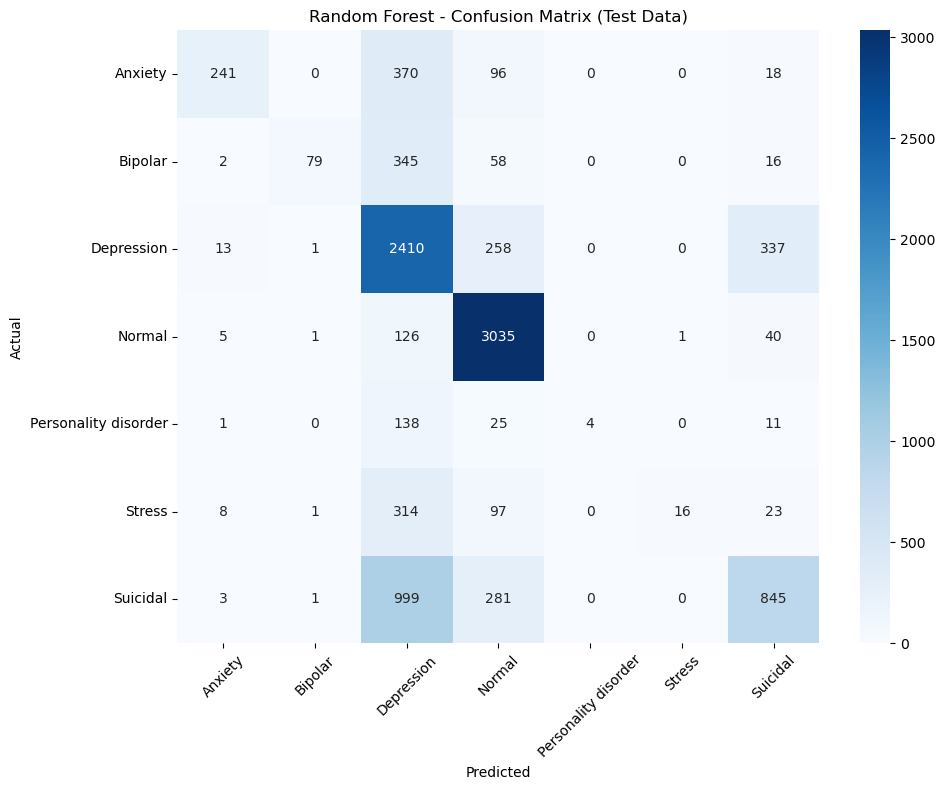

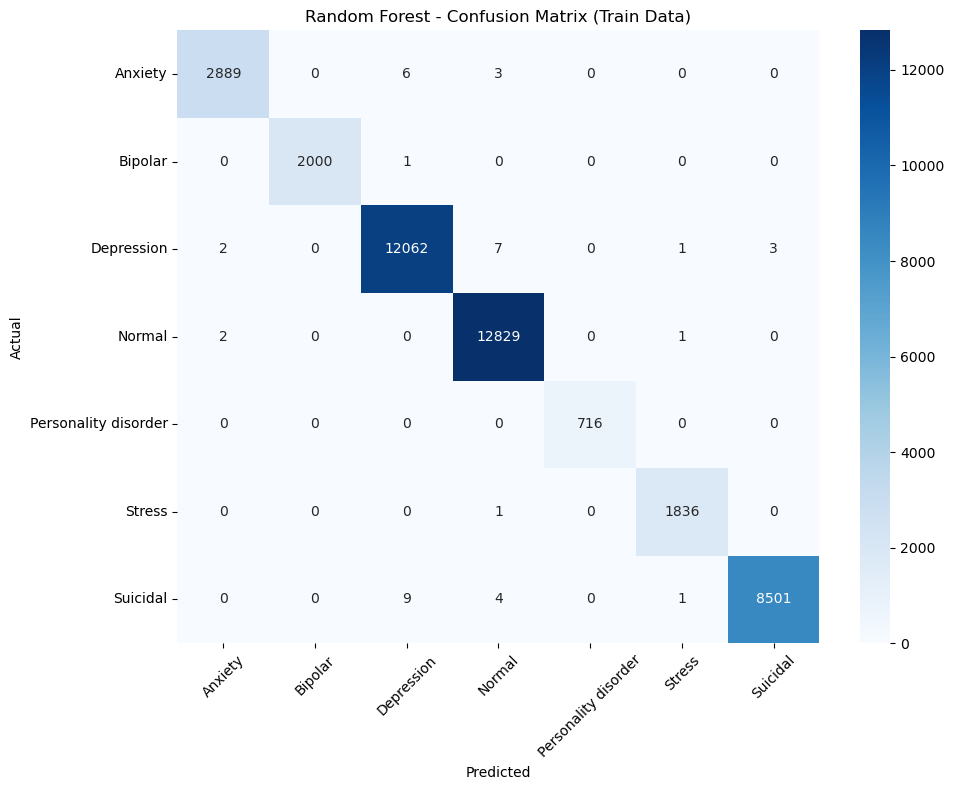

	 	 ---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.88      0.33      0.48       725
             Bipolar       0.95      0.16      0.27       500
          Depression       0.51      0.80      0.62      3019
              Normal       0.79      0.95      0.86      3208
Personality disorder       1.00      0.02      0.04       179
              Stress       0.94      0.03      0.07       459
            Suicidal       0.66      0.40      0.49      2129

            accuracy                           0.65     10219
           macro avg       0.82      0.38      0.41     10219
        weighted avg       0.70      0.65      0.61     10219

	 	 ---- Model Performance on Training data ----
                      precision    recall  f1-score   support

             Anxiety       1.00      1.00      1.00      2898
             Bipolar       1.00      1.00      1.00      2001
          Depression       1.00   

In [ ]:
print("!!!!! Naive Bayes - Logistic Regression - Random Forest with CountVectorizer !!!!!")
models_and_evaluation(X_train_count, X_test_count, y_train, y_test)

> Comparing the results of those three modls with the countvectorizer, it is clearly that logistic regression performs way better than others.
>
> We can see that the metrics on training data for both logistic regression and random forest show overfitting as there is a huge gap between the accuracy on training-test metrics.
>
> However, for this reason we also implemented cross validation and the score is almost equal to the test set. So, despite the possible overfitting results, we don't really pay attention to it as with the cross validation the model cannot memorize as he can do it without the cv
>
> Also, regarding the metrics on diseases:
> - Normal performs excelent - the model captures very good the normal cases
> - Anxiety - very good
> - Depression, Suicidal - moderate
> - the rest not that good

> Now, for saving some time in terms of computationally efficiency, it makes sense to stick to the Logistic Regression, apply stratified KFold cross validation to handle the imbalance and compare the results with the different vectorizers.

In [ ]:
# Creating a funtion just with logistic regression (we use it as baseline since it performs better) to save some computational time
# Where we will display only the classification report from cv training set (average metrics from the 5 folds) and the test (as we saw that it doesn't overfit comparing to pure training set)
def logreg(model, X_train_vec, X_test_vec, y_train, y_test, cv=5):

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_vec, y_train, cv=skf, scoring='accuracy')
    print(f"Cross-Validation Accuracy (mean over 5 folds): {cv_scores.mean():.4f}")
    print(f"Individual Fold Accuracies: {cv_scores}")

    # Fit the model
    model.fit(X_train_vec, y_train)

    # Prediction
    y_cv_train_pred = cross_val_predict(model, X_train_vec, y_train, cv=skf) # On cv training
    y_test_pred = model.predict(X_test_vec)  # On test

    # Reports
    print("\n\t\t---- Model Performance on Test data ----")
    print(classification_report(y_test, y_test_pred))

    print("\n\t\t---- Model Performance on CV Training data ----")
    print(classification_report(y_train, y_cv_train_pred))

> As we saw there is imbalance in the dataset. Let's try to balance it, giving the best-fitted weight to each class

In [ ]:
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

> Right now, having used cross validation FK folds and implemented 'balanced' class weight, we are sure that the model will perform as intented regarding the unbalanced data

In [ ]:
print('Logistic Regression with CountVect results')
logreg(log_reg, X_train_count, X_test_count, y_train, y_test)

Logistic Regression with CountVect results
Cross-Validation Accuracy (mean over 5 folds): 0.7197
Individual Fold Accuracies: [0.72636086 0.72146789 0.71510703 0.71388379 0.72192317]

		---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.71      0.74      0.73       725
             Bipolar       0.69      0.68      0.68       500
          Depression       0.71      0.59      0.64      3019
              Normal       0.87      0.94      0.91      3208
Personality disorder       0.41      0.44      0.43       179
              Stress       0.42      0.51      0.46       459
            Suicidal       0.62      0.65      0.64      2129

            accuracy                           0.72     10219
           macro avg       0.63      0.65      0.64     10219
        weighted avg       0.72      0.72      0.72     10219


		---- Model Performance on CV Training data ----
                      precision    rec

> Perfect, now from what we see, all of the classes are treated equally, we are positive that there is no over/underfitting and precision - recall - f1 score are almost the same and arount 0.72!
>
> However the results on 2 classes (stress, personality disorder) are not that satisfying as the model doesn't perform well/ do not capture true positives effectively.
>
> On the other hand, the model performs good on the rest of classes!!!! Lets try the same with TF-IDF

> #### <font color='red'> 4.2 Logistic Regression with TF-IDF

In [ ]:
print('Logistic Regression with TF-IDF results')
logreg(log_reg, X_train_tfidf, X_test_tfidf, y_train, y_test)

Logistic Regression with TF-IDF results
Cross-Validation Accuracy (mean over 5 folds): 0.7215
Individual Fold Accuracies: [0.72452599 0.72330275 0.71681957 0.72220183 0.72057744]

		---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.74      0.82      0.78       725
             Bipolar       0.67      0.74      0.70       500
          Depression       0.75      0.56      0.64      3019
              Normal       0.88      0.90      0.89      3208
Personality disorder       0.33      0.55      0.41       179
              Stress       0.40      0.64      0.49       459
            Suicidal       0.64      0.69      0.66      2129

            accuracy                           0.73     10219
           macro avg       0.63      0.70      0.66     10219
        weighted avg       0.74      0.73      0.73     10219


		---- Model Performance on CV Training data ----
                      precision    recall

> Here the results have not big difference with the counvectorizer, and also on the weaker classes perform worse.

> #### <font color='red'> 4.3 Logistic Regression with Trigrams and CountVectorizer

In [ ]:
print('Logistic Regression with Trigram & CountVect results')
logreg(log_reg, X_train_count_ngrams, X_test_count_ngrams, y_train, y_test)

Logistic Regression with Trigram & CountVect results
Cross-Validation Accuracy (mean over 5 folds): 0.7386
Individual Fold Accuracies: [0.74642202 0.73944954 0.73529052 0.73235474 0.73941767]

		---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.75      0.76      0.75       725
             Bipolar       0.78      0.64      0.71       500
          Depression       0.70      0.65      0.67      3019
              Normal       0.85      0.96      0.90      3208
Personality disorder       0.64      0.37      0.47       179
              Stress       0.53      0.45      0.49       459
            Suicidal       0.64      0.65      0.65      2129

            accuracy                           0.74     10219
           macro avg       0.70      0.64      0.66     10219
        weighted avg       0.73      0.74      0.74     10219


		---- Model Performance on CV Training data ----
                      precis

> #### <font color='red'> 4.4 Logistic Regression with Trigrams & TF-IDF

In [ ]:
print('Logistic Regression with Trigram & TF-IDF results')
logreg(log_reg, X_train_tfidf_ngrams, X_test_tfidf_ngrams, y_train, y_test)

Logistic Regression with Trigram & TF-IDF results
Cross-Validation Accuracy (mean over 5 folds): 0.7167
Individual Fold Accuracies: [0.71155963 0.71767584 0.72281346 0.7129052  0.71862001]

		---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.67      0.85      0.75       725
             Bipolar       0.62      0.73      0.67       500
          Depression       0.70      0.64      0.67      3019
              Normal       0.94      0.82      0.87      3208
Personality disorder       0.44      0.50      0.47       179
              Stress       0.48      0.53      0.51       459
            Suicidal       0.62      0.72      0.66      2129

            accuracy                           0.72     10219
           macro avg       0.64      0.68      0.66     10219
        weighted avg       0.74      0.72      0.73     10219


		---- Model Performance on CV Training data ----
                      precision

> #### <font color='red'> 4.5 Logistic Regression with Word2vec embedding

In [ ]:
print("=== Logistic Regression with Word2Vec Embeddings ===")
logreg(log_reg, X_train_w2v, X_test_w2v, y_train, y_test)

=== Logistic Regression with Word2Vec Embeddings ===
Cross-Validation Accuracy (mean over 5 folds): 0.6380
Individual Fold Accuracies: [0.6364526  0.63620795 0.6430581  0.6333945  0.64093467]

		---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.64      0.75      0.69       725
             Bipolar       0.50      0.74      0.60       500
          Depression       0.71      0.40      0.51      3019
              Normal       0.91      0.85      0.88      3208
Personality disorder       0.16      0.61      0.25       179
              Stress       0.26      0.60      0.37       459
            Suicidal       0.61      0.63      0.62      2129

            accuracy                           0.64     10219
           macro avg       0.54      0.65      0.56     10219
        weighted avg       0.71      0.64      0.66     10219


		---- Model Performance on CV Training data ----
                      precis

> #### <font color='red'> 4.6 Logistic Regression with BERT embedding

In [ ]:
print("=== Logistic Regression with BERT Embeddings ===")
logreg(log_reg, X_train_bert, X_test_bert, y_train, y_test)


=== Logistic Regression with BERT Embeddings ===
Cross-Validation Accuracy (mean over 5 folds): 0.6088
Individual Fold Accuracies: [0.60391437 0.61541284 0.61492355 0.60269113 0.60704673]

		---- Model Performance on Test data ----
                      precision    recall  f1-score   support

             Anxiety       0.57      0.67      0.61       725
             Bipolar       0.39      0.61      0.48       500
          Depression       0.68      0.38      0.48      3019
              Normal       0.89      0.85      0.87      3208
Personality disorder       0.14      0.54      0.22       179
              Stress       0.25      0.54      0.34       459
            Suicidal       0.58      0.59      0.58      2129

            accuracy                           0.61     10219
           macro avg       0.50      0.60      0.51     10219
        weighted avg       0.67      0.61      0.62     10219


		---- Model Performance on CV Training data ----
                      precision 

-----------------

## <font color='red'> 5. Neural Networks

> Now we will work on Word2Vec and Bert for Neural Networks

In [42]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Classes:", le.classes_)
print("y_train_enc sample:", y_train_enc[:10])


Classes: ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']
y_train_enc sample: [3 3 6 3 3 2 2 3 0 3]


> #### <font color='red'> 5.1 NN and BERT

In [32]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [44]:
#defining the number of classes
num_classes = len(le.classes_)
print(f"Num classes: {num_classes}")

Num classes: 7


In [45]:
# 2. Tokenizer & Model
# -------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_auth_token=False)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes,
    use_auth_token=False
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
# 3. Tokenization function
# -------------------------
def tokenize_texts(tokenizer, texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

In [47]:
# 4. Dataset class
# -------------------------
class EncodedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.input_ids      = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels         = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids':      self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels':         self.labels[idx]
        }


In [48]:
# 5. Prepare datasets
# -------------------------
train_enc = tokenize_texts(tokenizer, X_train_joined)
test_enc  = tokenize_texts(tokenizer, X_test_joined)

train_dataset = EncodedDataset(train_enc, y_train_enc)
test_dataset  = EncodedDataset(test_enc, y_test_enc)

In [49]:
# 6. Metrics function
# -------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1}

In [50]:
# 7. Training Arguments
# -------------------------
train_bs = 8
num_epochs = 3
total_steps = math.ceil(len(train_dataset)/train_bs) * num_epochs
warmup = int(0.1 * total_steps)

training_args = TrainingArguments(
    output_dir='./bert_output',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=train_bs,
    per_device_eval_batch_size=train_bs,
    warmup_steps=warmup,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_steps=500,
    save_steps=1000,
    save_total_limit=1,
    do_train=True,
    do_eval=True,
    report_to=["none"]
)

In [51]:
# 8. Trainer and training
# -------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Step,Training Loss
100,1.934100
200,1.458200
300,1.273700
400,1.246100
500,1.134800
600,1.027300
700,1.005300
800,0.940800
900,0.871100
1000,0.901900


TrainOutput(global_step=15330, training_loss=0.5841849156632893, metrics={'train_runtime': 1755.6004, 'train_samples_per_second': 69.846, 'train_steps_per_second': 8.732, 'total_flos': 8066163055449600.0, 'train_loss': 0.5841849156632893, 'epoch': 3.0})

In [55]:
# Predict on test set
pred_out = trainer.predict(test_dataset)
all_preds = pred_out.predictions.argmax(axis=-1)
all_labels = pred_out.label_ids

# Report and metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("Confusion Matrix:")
print(cm)


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.83      0.84      0.83       725
             Bipolar       0.82      0.75      0.78       500
          Depression       0.73      0.72      0.72      3019
              Normal       0.93      0.93      0.93      3208
Personality disorder       0.70      0.53      0.60       179
              Stress       0.60      0.58      0.59       459
            Suicidal       0.67      0.70      0.68      2129

            accuracy                           0.78     10219
           macro avg       0.75      0.72      0.73     10219
        weighted avg       0.78      0.78      0.78     10219

Accuracy:  0.7832
Precision: 0.7836
Recall:    0.7832
F1-score:  0.7831
Confusion Matrix:
[[ 611   16   47   14    2   28    7]
 [  18  373   62   12    7   10   18]
 [  46   35 2181   67   18   56  616]
 [  23    4   65 2994    2   52   68]
 [   6    3   41   11   94   16    8]
 [  30   13 

> #### <font color='red'> 5.2 NN and Word2vec

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# custom dataset for word2vec embeddings + labels
class W2VDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32) # convert numpy arrays to torch tensors
        self.y = torch.tensor(y, dtype=torch.long) # labels as long tensors for classification
    def __len__(self): # number of samples in the dataset
        return len(self.y)
    def __getitem__(self, idx):  # return a single (feature, label) pair
        return self.X[idx], self.y[idx]

# create a dataloader for training, enables batching and shuffling
train_loader = DataLoader(
    W2VDataset(X_train_w2v, y_train_enc),
    batch_size=32, shuffle=True
)
# create a dataloader for testing, no shuffling needed
test_loader = DataLoader(
    W2VDataset(X_test_w2v, y_test_enc),
    batch_size=32
)

In [ ]:
#feed-forward model
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

num_classes = len(le.classes_)
model_w2v = FeedForward(
    input_dim=w2v_model.vector_size,
    hidden_dim=128,
    num_classes=num_classes
)

In [ ]:
#training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_w2v.to(device)
optimizer = optim.Adam(model_w2v.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
# training loop
for epoch in range(1, 11):
    model_w2v.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model_w2v(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} — Loss: {total_loss/len(train_loader):.4f}")

Epoch 01 — Loss: 1.1688
Epoch 02 — Loss: 0.9607
Epoch 03 — Loss: 0.9116
Epoch 04 — Loss: 0.8881
Epoch 05 — Loss: 0.8727
Epoch 06 — Loss: 0.8603
Epoch 07 — Loss: 0.8549
Epoch 08 — Loss: 0.8484
Epoch 09 — Loss: 0.8442
Epoch 10 — Loss: 0.8342


In [ ]:
# Evaluation
model_w2v.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model_w2v(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

In [ ]:
# Report and metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)
cm = confusion_matrix(all_labels, all_preds)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("Confusion Matrix:")
print(cm)

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.78      0.68      0.73       725
             Bipolar       0.77      0.58      0.66       500
          Depression       0.64      0.56      0.59      3019
              Normal       0.87      0.92      0.89      3208
Personality disorder       0.85      0.06      0.11       179
              Stress       0.42      0.35      0.38       459
            Suicidal       0.57      0.74      0.64      2129

            accuracy                           0.70     10219
           macro avg       0.70      0.56      0.57     10219
        weighted avg       0.71      0.70      0.69     10219

Accuracy:  0.7004
Precision: 0.7056
Recall:    0.7004
F1-score:  0.6925
Confusion Matrix:
[[ 492    9  122   50    0   33   19]
 [  11  288  119   16    1   19   46]
 [  69   56 1679  163    0   79  973]
 [  20    3   86 2939    0   66   94]
 [   3    2  112   19   11   11   21]
 [  27    5 

## <font color='red'> 6. LLMs

> Quick Note: We run LLM on VS code, so the results appeared on the terminal, and thus, this is the reason they are attached as screenshot

In [ ]:
# Extract the cleaned & preprocessed dataset
# First we create a dataframe with text and their labels respectively
df_cleaned = pd.DataFrame({
    'text': X_test_joined,
    'true_label': y_test
})

df_cleaned.to_csv("llm_testset.csv", index=False)

In [ ]:
df_cleaned.head()

,text,true_label
50037,stopped lamictal noticed affecting lamictal we...,Bipolar
44966,delay 00,Normal
34025,health anxiety ocd line drawn health anxiety o...,Anxiety
27597,okay bit background girlfriend second year col...,Normal
3900,como que jyp que,Normal


In [ ]:
# Create a DataFrame out of trained & preprocessed X set with their corresponding labels of y_train
train_df_llm = pd.DataFrame({
    'text': X_train_joined,
    'label': y_train
}).reset_index(drop=True)

# Now for testing out the few-shot learning on GPT-4o we will give it some random examples from this dataset
few_shot = train_df_llm.sample(n=10, random_state=42)  # 10 random examples
for _, row in few_shot.iterrows():
    print(f'"{row["text"]}" → "{row["label"]}"')

> #### <font color='red'> 6.1 Zero-shot classification


In [ ]:
import os
from dotenv import load_dotenv
import pandas as pd
import openai
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ───── LOAD API KEY ─────
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
if not openai.api_key:
    raise RuntimeError("Missing OPENAI_API_KEY in .env")

# ───── CONFIG ─────
INPUT_CSV   = "Llm_testset.csv"
TEXT_COL    = "text"
LABEL_COL   = "true_label"
LABELS      = [
    "Anxiety",
    "Bipolar",
    "Depression",
    "Normal",
    "Personality disorder",
    "Stress",
    "Suicidal"
]
MODEL = "gpt-4o"

SYSTEM_PROMPT = (
    "You are a classifier. You **must** choose exactly one label from this list and reply "
    "with **only** that label (no extra words):\n\n" +
    "\n".join(f"- {lbl}" for lbl in LABELS)
)

def classify_zero_shot(text: str) -> str:
    """One API call, returns exactly one of LABELS or 'ERROR'."""
    try:
        resp = openai.chat.completions.create(
            model=MODEL,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user",   "content": text}
            ],
            temperature=0,
            max_tokens=8,
        )
        label = resp.choices[0].message.content.strip()
        return label if label in LABELS else "ERROR"
    except Exception:
        return "ERROR"

def main():
    # 1) Load & clean
    df = pd.read_csv(INPUT_CSV, usecols=[TEXT_COL, LABEL_COL])
    df = df.dropna(subset=[TEXT_COL])
    df[TEXT_COL] = df[TEXT_COL].astype(str)

    # 2) Classify entire dataset
    tqdm.pandas(desc="Zero-shot classifying full dataset")
    df["predicted"] = df[TEXT_COL].progress_apply(classify_zero_shot)

    # 3) Print classification report
    print(f"\n── Zero-Shot Performance on {len(df)} Samples ──\n")
    print(classification_report(df[LABEL_COL], df["predicted"], labels=LABELS, digits=2))

    # 4) Confusion matrix
    cm = confusion_matrix(df[LABEL_COL], df["predicted"], labels=LABELS)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=LABELS, yticklabels=LABELS
    )
    plt.title(f"Confusion Matrix (Zero-Shot, n={len(df)})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # 5) Class distribution bar plot
    class_counts = pd.DataFrame({
        "True": df[LABEL_COL].value_counts(),
        "Predicted": df["predicted"].value_counts()
    }).fillna(0)

    class_counts.plot.bar(figsize=(10, 6))
    plt.title("Class Distribution: True vs Predicted")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6) Classification report as heatmap
    report_dict = classification_report(
        df[LABEL_COL], df["predicted"], labels=LABELS, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report_dict).T.loc[LABELS, ["precision", "recall", "f1-score"]]

    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report (Precision, Recall, F1-score)")
    plt.tight_layout()
    plt.show()

    # 7) Overall performance metrics (bar chart)
    overall_metrics = {
        "accuracy": accuracy_score(df[LABEL_COL], df["predicted"]),
        "macro avg precision": report_dict["macro avg"]["precision"],
        "macro avg recall": report_dict["macro avg"]["recall"],
        "macro avg f1-score": report_dict["macro avg"]["f1-score"],
        "weighted avg f1-score": report_dict["weighted avg"]["f1-score"]
    }

    plt.figure(figsize=(8, 5))
    plt.barh(list(overall_metrics.keys()), list(overall_metrics.values()))
    plt.xlim(0, 1)
    plt.title("Overall Performance Metrics")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

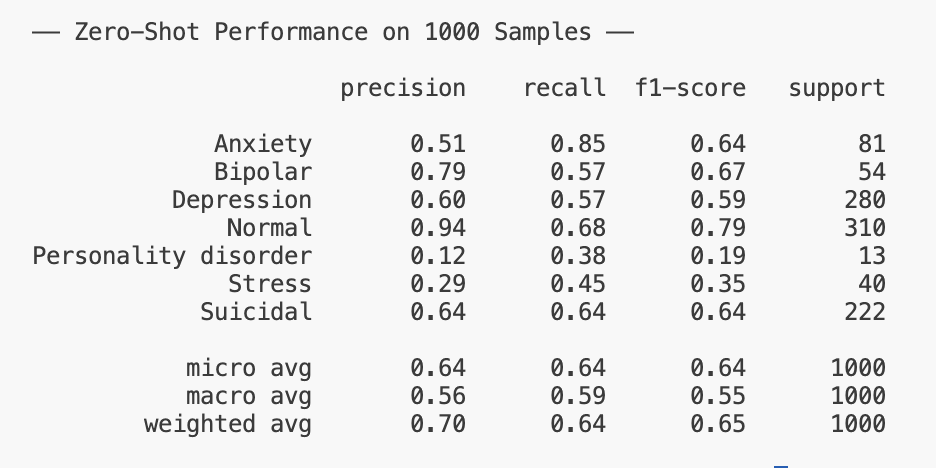

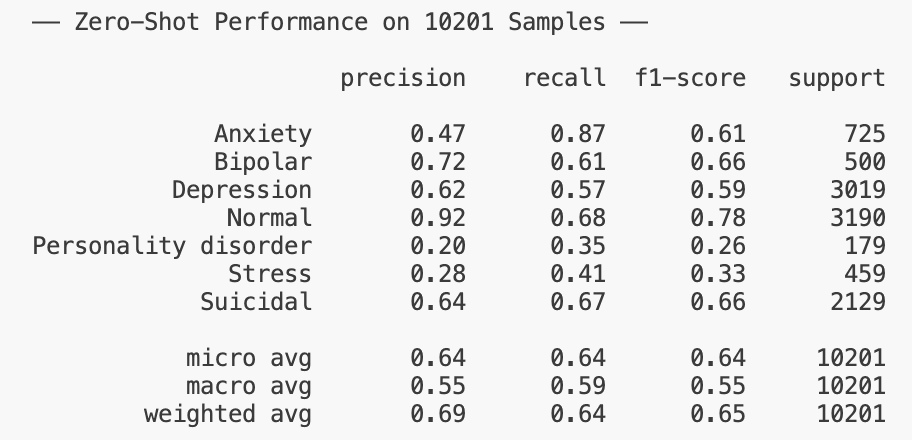

> #### <font color='red'> 6.2 Few-shot classification

In [ ]:
import os
from dotenv import load_dotenv
import pandas as pd
import openai
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ───── LOAD API KEY ─────
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
if not openai.api_key:
    raise RuntimeError("Missing OPENAI_API_KEY in .env")

# ───── CONFIG ─────
DATA_CSV     = "llm_testset.csv"
TEXT_COL     = "text"
LABEL_COL    = "true_label"
SEED         = 42
MODEL        = "gpt-4o"
LABELS       = [
    "Anxiety", "Bipolar", "Depression", "Normal",
    "Personality disorder", "Stress", "Suicidal"
]

SYSTEM_PROMPT = """You are a classifier. You **must** choose exactly one label from this list and reply with **only** that label (no extra words):

- Anxiety
- Bipolar
- Depression
- Normal
- Personality disorder
- Stress
- Suicidal"""

# ───── PROMPT BUILDER ─────
def build_prompt(example_batch, user_text):
    few_shot_str = "\n\n".join(
        f"Message: {ex[TEXT_COL]}\nCategory: {ex[LABEL_COL]}"
        for _, ex in example_batch.iterrows()
    )
    return f"{SYSTEM_PROMPT}\n\n{few_shot_str}\n\nMessage: {user_text}\nCategory:"

# ───── CLASSIFIER ─────
def classify_with_few_shot(text: str, example_batch: pd.DataFrame) -> str:
    prompt = build_prompt(example_batch, text)
    try:
        resp = openai.chat.completions.create(
            model=MODEL,
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=10
        )
        label = resp.choices[0].message.content.strip()
        return label if label in LABELS else "ERROR"
    except Exception:
        return "ERROR"

# ───── MAIN ─────
def main():
    # Load dataset
    df_full = pd.read_csv(DATA_CSV, usecols=[TEXT_COL, LABEL_COL]).dropna().reset_index(drop=True)

    # Select 2 examples per class for few-shot prompt
    few_shot = (
        df_full.groupby(LABEL_COL, group_keys=False)
        .apply(lambda x: x.sample(n=2, random_state=SEED))
        .reset_index(drop=True)
    )

    # Drop few-shot examples from evaluation set
    df_test = df_full.drop(index=few_shot.index).reset_index(drop=True)

    # Show few-shot examples
    print("\n── Few-Shot Examples Used ──\n")
    for _, row in few_shot.iterrows():
        print(f"\"{row[TEXT_COL]}\" → {row[LABEL_COL]}")

    # Run classification
    tqdm.pandas(desc="Classifying with Few-Shot GPT")
    df_test["predicted"] = df_test[TEXT_COL].progress_apply(
        lambda x: classify_with_few_shot(x, few_shot)
    )

    # ───── METRICS & VISUALS ─────
    print(f"\n── Few-Shot Performance on {len(df_test)} Samples ──\n")
    print(classification_report(df_test[LABEL_COL], df_test["predicted"], labels=LABELS, digits=2))

    # Confusion Matrix
    cm = confusion_matrix(df_test[LABEL_COL], df_test["predicted"], labels=LABELS)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f"Confusion Matrix (Few-Shot, n={len(df_test)})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Class Distribution
    class_counts = pd.DataFrame({
        "True": df_test[LABEL_COL].value_counts(),
        "Predicted": df_test["predicted"].value_counts()
    }).fillna(0)
    class_counts.plot.bar(figsize=(10, 6))
    plt.title("Class Distribution: True vs Predicted (Few-Shot)")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Heatmap of precision, recall, F1
    report_dict = classification_report(
        df_test[LABEL_COL], df_test["predicted"], labels=LABELS, output_dict=True, zero_division=0
    )
    report_df = pd.DataFrame(report_dict).T.loc[LABELS, ["precision", "recall", "f1-score"]]
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report (Precision, Recall, F1-score)")
    plt.tight_layout()
    plt.show()

    # Overall Metrics
    overall_metrics = {
        "accuracy": accuracy_score(df_test[LABEL_COL], df_test["predicted"]),
        "macro avg precision": report_dict["macro avg"]["precision"],
        "macro avg recall": report_dict["macro avg"]["recall"],
        "macro avg f1-score": report_dict["macro avg"]["f1-score"],
        "weighted avg f1-score": report_dict["weighted avg"]["f1-score"]
    }
    plt.figure(figsize=(8, 5))
    plt.barh(list(overall_metrics.keys()), list(overall_metrics.values()))
    plt.xlim(0, 1)
    plt.title("Overall Performance Metrics (Few-Shot)")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

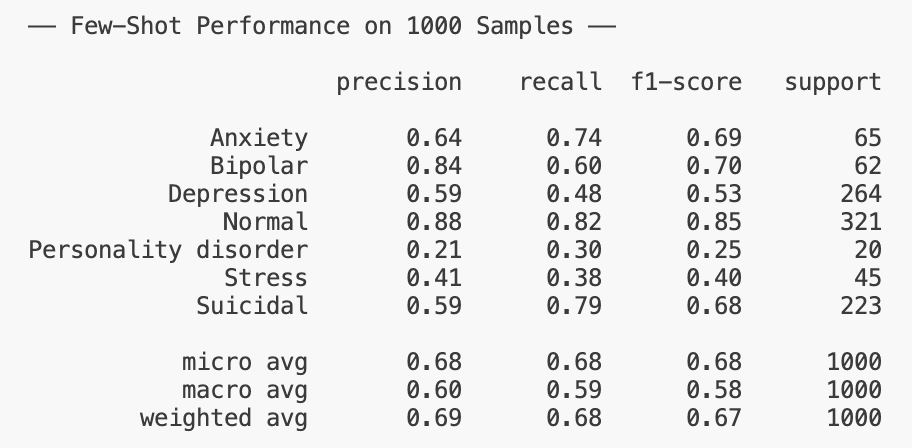

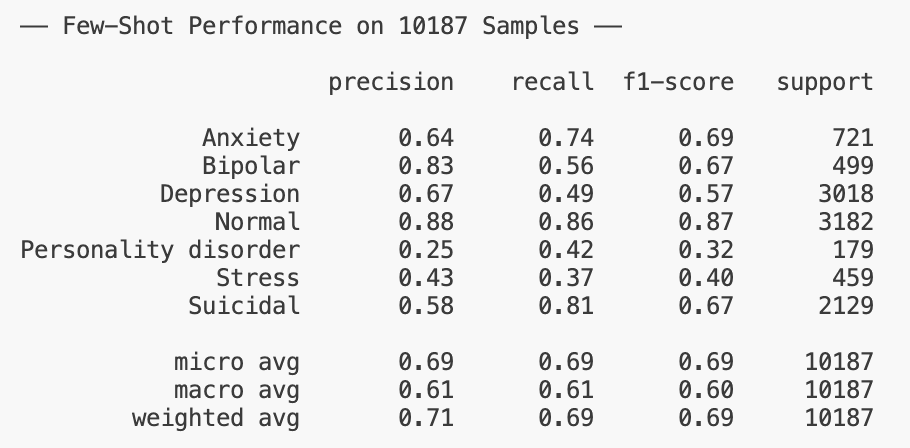